In [1]:
# Base libraries
import numpy as np
from tqdm import trange

# Data vizualization libraries
import matplotlib.pyplot as plt

# Pyinterpolate libraries
from pyinterpolate.semivariance.areal_semivariance.areal_semivariance import ArealSemivariance
from pyinterpolate.semivariance.semivariogram_fit.fit_semivariance import TheoreticalSemivariogram
from pyinterpolate.semivariance.semivariogram_estimation.calculate_semivariance import \
    calculate_semivariance  # Experimental semivariogram
from pyinterpolate.semivariance.semivariogram_estimation.calculate_semivariance import \
    calculate_weighted_semivariance

In [2]:
import csv
from operator import itemgetter
import warnings

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyinterpolate.distance.calculate_distances import calc_block_to_block_distance
#from pyinterpolate.semivariance.semivariogram_estimation.calculate_semivariance import calculate_semivariance
#from pyinterpolate.semivariance.semivariogram_fit.fit_semivariance import TheoreticalSemivariogram
from pyinterpolate.semivariance.semivariogram_estimation.calculate_semivariance import calculate_weighted_semivariance
from pyinterpolate.semivariance.areal_semivariance.within_block_semivariance.calculate_semivariance_within_blocks\
    import calculate_semivariance_within_blocks
from pyinterpolate.semivariance.areal_semivariance.within_block_semivariance.calculate_average_semivariance\
    import calculate_average_semivariance
from pyinterpolate.semivariance.areal_semivariance.block_to_block_semivariance.\
    calculate_block_to_block_semivariance import calculate_block_to_block_semivariance

In [65]:
class TheoreticalSemivariogramss:
    """
    Class calculates theoretical semivariogram. Class takes two parameters during initialization:
    points_array - (numpy array) analysed points where the last column represents values, typically x, y, value,
    empirical_semivariance - (numpy array) semivariance where first row of array represents lags and the second row
        represents semivariance's values for a given lag.
    Available methods:
    - predict() - method predicts value of the unknown point based on the chosen model,
    - fit_semivariance() - Method fits experimental points into chosen semivariance model type,
    - find_optimal_model() - Method fits experimental points into all available models and choose one with the lowest
        error.
    Available theoretical models:
    - spherical_model(distance, nugget, sill, semivar_range)
    - gaussian_model(distance, nugget, sill, semivar_range)
    - exponential_model(distance, nugget, sill, semivar_range)
    - linear_model(distance, nugget, sill, semivar_range)
    Additional methods:
    - calculate_base_error(),
    - show_experimental_semivariogram() - shows semivariogram which is a part of the class object's instance,
    - show_semivariogram() - shows experimental semivariogram with theoretical model (if it was calculated).
    """

    def __init__(self, points_array=None, empirical_semivariance=None, verbose=False):
        """
        INPUT:
        :param points_array: (numpy array) [point x, point y, value] (optional if model parameters are imported)
        :param empirical_semivariance: (numpy array) array of pair of lag and semivariance values where
                 semivariance[:, 0] = array of lags
                 semivariance[:, 1] = array of lag's values
                 semivariance[:, 2] = array of number of points in each lag.
                 (optional if model parameters are imported)
        :param verbose: (bool) if True then all messages are printed, otherwise nothing.
        """

        self.points_values = points_array
        self.empirical_semivariance = empirical_semivariance
        self.verbose = verbose
        self.theoretical_model = None
        self.chosen_model_name = None
        self.nugget = None
        self.range = None
        self.sill = None
        self.model_error = None
        self.is_weighted = False

    # MODELS

    @staticmethod
    def spherical_model(lags, nugget, sill, semivar_range):
        """
        gamma = nugget + sill*[(3/2)*a - (1/2)*(a**3)], 0 <= lag <= range
        gamma = nugget + sill, lag > range
        gamma = 0, lag == 0
        where:
        a = lag / range
        INPUT:
        :param lags: array of lags from empirical semivariance,
        :param nugget: scalar,
        :param sill: scalar,
        :param semivar_range: optimal range calculated by fit_semivariance method.
        OUTPUT:
        :return: an array of modeled values for given range. Values are calculated based on the spherical model.
        """

        a = lags / semivar_range
        a1 = 3 / 2 * a
        a2 = 1 / 2 * a ** 3

        gamma = np.where((lags <= semivar_range),
                         (nugget + sill * (a1 - a2)),
                         (nugget + sill))

        return gamma

    @staticmethod
    def exponential_model(lags, nugget, sill, semivar_range):
        """
        gamma = nugget + sill*[1 - exp(-lag/range)], distance > 0
        gamma = 0, lag == 0
        INPUT:
        :param lags: array of lags from empirical semivariance,
        :param nugget: scalar,
        :param sill: scalar,
        :param semivar_range: optimal range calculated by fit_semivariance method.
        OUTPUT:
        :return: an array of modeled values for given range. Values are calculated based on the exponential model.
        """

        try:
            gamma = nugget + sill * (1 - np.exp(-lags / semivar_range))
        except TypeError:
            lags = lags.astype(float)
            semivar_range = float(semivar_range)
            gamma = nugget + sill * (1 - np.exp(-lags / semivar_range))

        return gamma

    @staticmethod
    def linear_model(lags, nugget, sill, semivar_range):
        """
        gamma = nugget + sill*(lag/range), 0 <= lag <= range
        gamma = nugget + sill, lag > range
        gamma = 0, lag == 0
        INPUT:
        :param lags: array of lags from empirical semivariance,
        :param nugget: scalar,
        :param sill: scalar,
        :param semivar_range: optimal range calculated by fit_semivariance method.
        OUTPUT:
        :return: an array of modeled values for given range. Values are calculated based on the linear model.
        """

        gamma = np.where((lags <= semivar_range),
                         (nugget + sill * (lags / semivar_range)),
                         (nugget + sill))

        return gamma

    @staticmethod
    def gaussian_model(lags, nugget, sill, semivar_range):
        """
        gamma = nugget + sill*[1 - exp(lag**2 / range**2)], lag > 0
        gamma = 0, lag == 0
        INPUT:
        :param lags: array of ranges from empirical semivariance,
        :param nugget: scalar,
        :param sill: scalar,
        :param semivar_range: optimal range calculated by fit_semivariance method.
        OUTPUT:
        :return: an array of modeled values for given range. Values are calculated based on the gaussian model.
        """
        gamma = nugget + sill * (1 - np.exp(-1*(lags ** 2 / semivar_range ** 2)))

        if lags[0] == 0:
            gamma[0] = 0

        return gamma
    
    def fit_semivariance(self, model_type, number_of_ranges=16):
        """
        Method fits experimental points into chosen semivariance model type.
        INPUT:
        :param model_type: (str) 'exponential', 'gaussian', 'linear', 'spherical',
        :param number_of_ranges: (int) deafult = 16. Used to create an array of equidistant ranges
            between minimal range of empirical semivariance and maximum range of empirical semivariance.
        OUTPUT:
        :return: (model_type, model parameters)
        """

        # model
        models = {
            'spherical': self.spherical_model,
            'exponential': self.exponential_model,
            'linear': self.linear_model,
            'gaussian': self.gaussian_model,
        }
        model = models[model_type]
        self.chosen_model_name = model_type
        self.theoretical_model = model

        # sill
        sill = np.var(self.points_values[:, -1])+3500

        # nugget
        if self.empirical_semivariance[0][0] != 0:
            nugget = 0
        else:
            nugget = self.empirical_semivariance[0][1]

        # range
        minrange = self.empirical_semivariance[:, 0][1]
        maxrange = self.empirical_semivariance[:, 0][-1]
        ranges = np.linspace(minrange, maxrange, number_of_ranges)
        optimal_range = self.calculate_range(model, ranges, nugget, sill)

        # output model
        self.nugget = 0
        self.sill = sill
        self.range = optimal_range

        # model error
        self.model_error = self.calculate_model_error(model, self.nugget, self.sill, self.range)

        return model_type

    def find_optimal_models(self, weighted=False, number_of_ranges=16):
        """
        Method fits experimental points into all available models and choose one with the lowest error.
        INPUT:
        :param weighted: (bool) default=False. If True then each lag is weighted by:
            sqrt(N(h))/gamma_{exp}(h)
            where:
            - N(h) - number of point pairs in a given range, gamma_{exp}(h) - value of experimental semivariogram for h.
        :param number_of_ranges: (int) default=16. Used to create an array of equidistant ranges
            between minimal range of empirical semivariance and maximum range of empirical semivariance.
        """

        if weighted:
            self.is_weighted = True

        # models
        models = {
            'spherical': self.spherical_model,
            'exponential': self.exponential_model,
            'linear': self.linear_model,
        }

        # calculate base error for a flat line
        base_error = self.calculate_base_error()

        # sill
        sill = np.var(self.points_values[:, -1])+3500

        # nugget
        #if self.empirical_semivariance[0][0] != 0:
            #nugget = 0
        #else:
            #nugget = self.empirical_semivariance[0][1]
        nugget = 0 

        # range
        minrange = self.empirical_semivariance[:, 0][1]
        maxrange = self.empirical_semivariance[:, 0][-1]
        ranges = np.linspace(minrange, maxrange, number_of_ranges)

        # Calculate model errors
        model_errors = [('Linear (LS) reference model', base_error, None)]
        for model in models:
            optimal_range = self.calculate_range(models[model], ranges, nugget, sill)

            # output model
            model_error = self.calculate_model_error(models[model], nugget, sill, optimal_range)

            model_errors.append((model, model_error, [nugget, sill, optimal_range]))
            if self.verbose:
                print('Model: {}, error value: {}'.format(model, model_error))

        # Select the best model
        sorted_errors = sorted(model_errors, key=itemgetter(1))

        if sorted_errors[0][0] == 'Linear (LS) reference model':
            # This is unlikely case when error estimated as the squared distance between extrapolated values and
            # x axis is smaller than models' errors

            model_name = sorted_errors[1][0]
            model_error = sorted_errors[1][1]
            model_params = sorted_errors[1][2]

            warning_msg = 'WARNING: linear model fitted to the experimental variogram is better than the core models!'
            warnings.warn(warning_msg)
            if self.verbose:
                print('Chosen model: {}, with value of: {}.'.format(
                    model_name, model_error
                ))
        else:
            model_name = sorted_errors[0][0]
            model_error = sorted_errors[0][1]
            model_params = sorted_errors[0][2]
            if self.verbose:
                print('Chosen model: {}, with value: {}.'.format(
                    model_name, model_error
                ))

        self.theoretical_model = models[model_name]
        self.nugget = model_params[0]
        self.sill = model_params[1]
        self.range = model_params[2]
        self.chosen_model_name = model_name
        self.model_error = model_error
        return model_name

    def calculate_range(self, model, ranges, nugget, sill):
        errors = []
        for r in ranges:
            x = (self.empirical_semivariance[:, 1] - model(self.empirical_semivariance[:, 0], nugget, sill, r))
            x = x ** 2
            errors.append(np.mean(x))
        range_pos = np.argmin(errors)
        optimal_rg = ranges[range_pos]
        return optimal_rg

    def calculate_values(self):
        output_model = self.theoretical_model(self.empirical_semivariance[:, 0],
                                              self.nugget,
                                              self.sill,
                                              self.range)
        return output_model

    @staticmethod
    def _curve_fit_function(x, a, b):
        """
        Method fits data into a 1st order polynomial curve where:
            y = a * x + b
        INPUT:
        :param a: number or numpy array,
        :param b: number or numpy array,
        :param x: number or numpy array.
        OUTPUT:
        :return: y -> a * x + b | number or numpy array.
        """

        y = a * x + b
        return y

    def _get_weights(self):
        """
        Method creates weights based on the lags for each semivariogram point
        OUTPUT:
        :returns: (numpy array)
        """

        nh = np.sqrt(self.empirical_semivariance[:, 2])
        vals = self.empirical_semivariance[:, 1]
        nh_divided_by_vals = np.divide(nh,
                                       vals,
                                       out=np.zeros_like(nh),
                                       where=vals != 0)
        return nh_divided_by_vals

    def calculate_base_error(self):
        """
        Method calculates base error as the difference between the least squared model
            of experimental semivariance and the experimental semivariance points.
        OUTPUT:
        :returns: (float) mean squared difference error
        """

        popt, _pcov = curve_fit(self._curve_fit_function,
                                self.empirical_semivariance[:, 0],
                                self.empirical_semivariance[:, 1])
        a, b = popt
        y = self._curve_fit_function(self.empirical_semivariance[:, 0],
                                     a, b)
        error = np.sqrt((self.empirical_semivariance[:, 1] - y) ** 2)

        if not self.is_weighted:
            mean_error = np.mean(error)
            return mean_error
        else:
            weights = self._get_weights()
            mean_error = np.mean(weights * error)
            return mean_error

    def calculate_model_error(self, model, nugget, sill, semivar_range):
        """
        Function calculates error between specific models and experimental curve.
        OUTPUT:
        :returns: (float) mean squared difference between model and experimental variogram.
        """
        error = np.sqrt((self.empirical_semivariance[:, 1] - model(self.empirical_semivariance[:, 0],
                                                                   nugget,
                                                                   sill,
                                                                   semivar_range)) ** 2)
        if not self.is_weighted:
            return np.mean(error)
        else:
            weights = self._get_weights()
            return np.mean(weights * error)

    def predict(self, distances):
        """
        INPUT:
        :param distances: array of distances from points of known locations and values to the point of
        unknown value,
        OUTPUT:
        :return: model with predicted values.
        """

        output_model = self.theoretical_model(distances,
                                              self.nugget,
                                              self.sill,
                                              self.range)
        return output_model

    def export_model(self, filename):
        """
        Function exports semivariance model to the csv file with columns:
        - name: [model name],
        - nugget: [value],
        - sill: [value],
        - range: [value],
        - model_error: [value]"""

        model_parameters = {
            'name': self.chosen_model_name,
            'nugget': self.nugget,
            'sill': self.sill,
            'range': self.range,
            'model_error': self.model_error
        }

        csv_cols = list(model_parameters.keys())
        try:
            with open(filename, 'w') as semivar_csv:
                writer = csv.DictWriter(semivar_csv, fieldnames=csv_cols)
                writer.writeheader()
                writer.writerow(model_parameters)
        except IOError:
            raise IOError("I/O error, provided path for semivariance parameters is not valid")

    def import_model(self, filename):
        """
        Function imports semivariance model and updates it's parameters
        (model name, nugget, sill, range, model error)."""

        models = {
            'spherical': self.spherical_model,
            'exponential': self.exponential_model,
            'linear': self.linear_model,
            'gaussian': self.gaussian_model,
        }

        csv_cols = ['name', 'nugget', 'sill', 'range', 'model_error']
        try:
            with open(filename, 'r') as semivar_csv:
                reader = csv.DictReader(semivar_csv, fieldnames=csv_cols)
                next(reader)
                for row in reader:
                    self.nugget = float(row['nugget'])
                    self.sill = float(row['sill'])
                    self.range = float(row['range'])
                    self.chosen_model_name = row['name']
                    if row['model_error']:
                        self.model_error = float(row['model_error'])
                    else:
                        self.model_error = None
                    try:
                        self.theoretical_model = models[self.chosen_model_name]
                    except KeyError:
                        raise KeyError('You have provided wrong model name. Available names: spherical, gaussian, '
                                       'exponential, linear.')
        except IOError:
            raise IOError("I/O error, provided path for semivariance parameters is not valid")

    def export_semivariance(self, filename):
        """
        Function exports empirical and theoretical semivariance models into csv file.
        INPUT:
        :param filename: (str) Path to the csv file to be stored.
        """

        if self.theoretical_model is None:
            raise RuntimeError('Theoretical semivariogram is not calculated. \
            Did you run fit_semivariance(model_type, number_of_ranges) on your model?')

        if not isinstance(filename, str):
            raise ValueError('Given path is not a string type')

        if not filename.endswith('.csv'):
            filename = filename + '.csv'

        # Create DataFrame to export

        theo_values = self.calculate_values()
        dt = {
            'lag': self.empirical_semivariance[:, 0],
            'experimental': self.empirical_semivariance[:, 1],
            'theoretical': theo_values
        }
        df = pd.DataFrame.from_dict(dt, orient='columns')
        df.to_csv(filename, index=False)

    def show_experimental_semivariogram(self):
        """
        Function shows experimental semivariogram of a given model.
        """
        plt.figure(figsize=(10, 10))
        plt.plot(self.empirical_semivariance[:, 0], self.empirical_semivariance[:, 1], 'bo')
        plt.title('Experimental semivariogram')
        plt.xlabel('Distance')
        plt.ylabel('Semivariance')
        plt.show()

    def show_semivariogram(self):
        """
        Function shows experimental and theoretical semivariogram in one plot.
        """
        if self.theoretical_model is None:
            raise RuntimeError('Theoretical semivariogram is not calculated. \
            Did you run fit_semivariance(model_type, number_of_ranges) on your model?')

        x = self.calculate_values()
        plt.figure(figsize=(12, 12))
        plt.plot(self.empirical_semivariance[:, 0], self.empirical_semivariance[:, 1], 'bo')
        plt.plot(self.empirical_semivariance[:, 0], x, color='red')
        plt.legend(['Empirical semivariogram', 'Theoretical semivariogram - {} model'.format(
            self.chosen_model_name
        )])
        title_text = 'Empirical and theoretical semivariogram comparison, model error = {:.2f}'.format(
            self.model_error
        )
        plt.title(title_text)
        plt.xlabel('Distance')
        plt.ylabel('Semivariance')
        plt.show()

In [66]:
from pyinterpolate.transform import set_areal_weights

In [67]:
class RegularizedSemivariogram:
    """
    Class performs deconvolution of semivariogram of areal data. Whole procedure is based on the iterative process
    described in: Goovaerts P., Kriging and Semivariogram Deconvolution in the Presence of Irregular Geographical
    Units, Mathematical Geology 40(1), 101-128, 2008.
    Class works as follow:
    - initialize your object (no parameters),
    - then use fit() method to build initial point support model,
    - then use transform() method to perform semivariogram regularization,
    - save semivariogram model with export_model() method.
    Class public methods:
    fit() - fits areal data and point support data into a model, initialize experimental semivariogram,
    theoretical semivariogram model, regularized point support model and deviation.
    transform() - performs semivariogram regularization, which is an iterative process.
    export_regularized_model() - Function exports final regularized model parameters into specified csv file.
    show_baseline_semivariograms() - Function shows experimental semivariogram, initial theoretical semivariogram and
        initial regularized semivariogram after fit() operation.
    show_semivariograms() - plots experimental semivariogram of area data, theoretical curve of area data,
        regularized model values and regularized model theoretical curve.
    """
    def __init__(self):
        """
        Class has multiple params, some of them are designed to control process of regularization and other are storing
        semivariogram models and experimental (or regularized) values of semivariance.
        """

        # Procedure control parameters
        self.iter = 0
        self.max_iters = None

        self.deviation_ratio = 1
        self.min_deviation_ratio = None

        self.diff_decrease = 1
        self.min_diff_decrease = None

        self.const_d_stat_reps = 0
        self.min_diff_decrease_reps = None

        self.weight_error_lags = False

        self.weight_change = False

        self.store_models = False

        # Regularization parameters
        self.ranges = None
        self.weights = []
        self.deviations = []

        # Initial semivariogram models and parameters
        self.experimental_semivariogram_of_areal_data = None
        ###
        self.experimental_weighted_semivariogram_of_areal_data = None
        self.initial_theoretical_model_of_areal_data = None
        ###
        self.initial_theoretical_weighted_model_of_areal_data = None
        self.initial_regularized_model = None
        self.initial_deviation = None
        
        self.areal_weights = None

        # Temporary semivariogram models and class parameters
        self.temp_experimental_semivariogram = None
        self.temp_theoretical_semivariogram_model = None
        self.temp_regularized_model = None
        self.temp_deviation = None

        # Optimal semivariogram models and params
        self.optimal_theoretical_model = None
        self.optimal_regularized_model = None
        self.optimal_deviation = None

        # Final models
        self.final_theoretical_model = None
        self.final_optimal_model = None

        # Data
        self.areal_data = None
        self.areal_max_range = None
        self.areal_step_size = None
        self.point_support_data = None

        # Stored models if self.store_models is True
        self.t_exp_list = []
        self.t_theo_list = []
        self.t_reg_list = []
        
        
    def _regularize(self, empirical_semivariance, semivariance_model):
        """
        Function regularizes semivariogram with ArealSemivariance class.
        INPUT:
        :param empirical_semivariance: experimental values of semivariance as an array of the form:
            [[column with lags, column with values, column with number of points within lag]],
        :param semivariance_model: TheoreticalSemivariance model,
        OUTPUT:
        :return: regularized semivariance values (array).
        """

        # Initialize areal semivariance object
        areal_semivariance = ArealSemivariance(self.areal_data,
                                               self.areal_step_size,
                                               self.areal_max_range,
                                               self.point_support_data,
                                               weighted_semivariance=self.weight_error_lags)

        # Regularize semivariogram of areal data
        theoretically_regularized_model_values = areal_semivariance.regularize_semivariogram(
            empirical_semivariance=empirical_semivariance,
            theoretical_semivariance_model=semivariance_model)

        return theoretically_regularized_model_values[:, 1]
    
    def _calculate_deviation(self, regularized_model, theoretical_model):
        """
        Function calculates deviation between experimental and theoretical semivariogram over given lags.
        INPUT:
        :param regularized_model: (numpy array) array of the values generated for the regularized model,
        :param theoretical_model: (TheoreticalSemivariance) theoretical model of data,
        OUTPUT:
        :return deviation: (float) scalar which describes deviation between semivariograms.
        """

        lags = self.experimental_semivariogram_of_areal_data[:, 0]
        theoretical_values = theoretical_model.predict(lags)
        regularized_values = regularized_model

        deviation = np.abs(regularized_values - theoretical_values)
        deviation = np.divide(deviation,
                              theoretical_values,
                              out=np.zeros_like(deviation),
                              where=theoretical_values != 0)
        deviation = np.mean(deviation)
        return deviation
    
    def _rescale_optimal_point_support(self):
        """Function rescales the optimal point support model and creates new experimental values for each lag based on
            the equation:
            y(1)(h) = y_opt(h) x w(h)
            w(h) = 1 + [(y_exp_v(h) - y_opt_v(h) / (s^2 * sqrt(iter))]
            where:
            - s = sill of the model y_exp_v
            - iter = iteration number
        OUTPUT:
        :return rescalled_point_support_semivariogram: (numpy array) of the form [[lag, semivariance, number of points]]
        """
        lags = self.experimental_semivariogram_of_areal_data[:, 0]

        y_opt_h = self.optimal_theoretical_model.predict(lags)

        if not self.weight_change:
            sill = self.initial_theoretical_model_of_areal_data.sill
            denominator = sill * np.sqrt(self.iter)

            y_exp_v_h = self.initial_theoretical_model_of_areal_data.predict(lags)
            y_opt_v_h = self.optimal_regularized_model

            numerator = (y_exp_v_h - y_opt_v_h)

            w = 1 + (numerator / denominator)
        else:
            w = 1 + ((self.weights[-1] - 1) / 2)

        rescalled = self.experimental_semivariogram_of_areal_data.copy()
        rescalled[:, 1] = y_opt_h * w

        return rescalled, w
    
    def _check_deviation_ratio(self):
        return bool(self.deviation_ratio <= self.min_deviation_ratio)

    def _check_diff_d_stat(self):
        if self.diff_decrease <= 0:
            if np.abs(self.diff_decrease) < self.min_diff_decrease:

                if self.const_d_stat_reps >= self.min_diff_decrease_reps:
                    return True

                self.const_d_stat_reps += 1
                return False

            if self.const_d_stat_reps >= 1:

                self.const_d_stat_reps = self.const_d_stat_reps - 1
                return False

            return False
        return False

    def _check_algorithm(self):
        t1 = self._check_deviation_ratio()  # Default False
        t2 = self._check_diff_d_stat()  # Default False

        cond = not (t1 or t2)  # Default False

        return cond
    
    def fit(self, areal_data, areal_step_size, max_areal_range,
            point_support_data, weighted_lags=True, store_models=False):
        """
        Function fits area and point support data to the initial regularized models.
        INPUT:
        :param areal_data: (numpy array) areal data prepared with the function prepare_areal_shapefile(), where data is
            a numpy array in the form: [area_id, area_geometry, centroid x, centroid y, value],
        :param areal_step_size: (float) step size between each lag, usually it is a half of distance between lags,
        :param max_areal_range: (float) max distance to perform distance and semivariance calculations,
        :param point_support_data: (numpy array) point support data prepared with the function get_points_within_area(),
            where data is a numpy array in the form: [area_id, [point_position_x, point_position_y, value]],
        :param weighted_lags: (bool) lags weighted by number of points; if True then during semivariogram fitting error
            of each model is weighted by number of points for each lag. In practice it means that more reliable data
            (lags) have larger weights and semivariogram is modeled to better fit to those lags,
        :param store_models: (bool) if True then experimental, regularized and theoretical models are stored in lists
            after each iteration. It is important for a debugging process.
        """

        # Update data class params
        self.areal_data = areal_data
        self.areal_max_range = max_areal_range
        self.areal_step_size = areal_step_size
        self.point_support_data = point_support_data
        self.ranges = len(np.arange(0, self.areal_max_range, self.areal_step_size))
        self.weight_error_lags = weighted_lags

        self.store_models = store_models

        # Compute experimental semivariogram of areal data from areal centroids

        areal_centroids = areal_data[:, 2:]

        self.experimental_semivariogram_of_areal_data = calculate_semivariance(
            areal_centroids,
            areal_step_size,
            max_areal_range
        )
        ###
        self.areal_weights = set_areal_weights(self.areal_data,self.point_support_data)
        self.experimental_weighted_semivariogram_of_areal_data = calculate_weighted_semivariance(self.areal_weights,self.areal_step_size,
                                                                                                 self.areal_max_range)
        

        # Compute theoretical semivariogram of areal data from areal centroids

        self.initial_theoretical_model_of_areal_data = TheoreticalSemivariogram(
            areal_centroids,
            self.experimental_semivariogram_of_areal_data
        )

        self.initial_theoretical_model_of_areal_data.find_optimal_model(
            weighted=weighted_lags,
            number_of_ranges=self.ranges
        )
        ###
        self.initial_theoretical_weighted_model_of_areal_data = TheoreticalSemivariogramss(areal_centroids,
                                                                                           self.experimental_weighted_semivariogram_of_areal_data,
                                                                                           verbose=False)
        ###
        self.initial_theoretical_weighted_model_of_areal_data.find_optimal_models(weighted=weighted_lags,
                                                                                  number_of_ranges=self.ranges)

        # Regularize model
        self.initial_regularized_model = self._regularize(self.experimental_weighted_semivariogram_of_areal_data,
                                                          self.initial_theoretical_weighted_model_of_areal_data)

        # Calculate d-stat
        self.initial_deviation = self._calculate_deviation(self.initial_regularized_model,
                                                           self.initial_theoretical_model_of_areal_data)

        self.deviations.append(self.initial_deviation)
        
    def transform(self, max_iters=25, min_deviation_ratio=0.01, min_diff_decrease=0.01, min_diff_decrease_reps=3):
        """
        Function transofrms fitted data and performs semivariogram regularization iterative procedure.
        INPUT:
        :param max_iters: (int) maximum number of iterations,
        :param min_deviation_ratio: (float) minimum ratio between deviation and initial deviation (D(i) / D(0)) below
            each algorithm is stopped,
        :param min_diff_decrease: (float) minimum difference between new and optimal deviation divided by
            optimal deviation: (D(i) - D(opt)) / D(opt). If it is recorded n times (controled by
            the min_diff_d_stat_reps param) then algorithm is stopped,
        :param min_diff_decrease_reps: (int) number of iterations when algorithm is stopped if condition
            min_diff_d_stat is fulfilled.
        """

        # Check if data is fitted
        if self.initial_regularized_model is None:
            raise RuntimeError('Before transform you must fit areal data and calculate initial point support models')

        # Update class control params
        self.iter = 1
        self.max_iters = max_iters

        self.min_deviation_ratio = min_deviation_ratio

        self.min_diff_decrease = min_diff_decrease
        self.min_diff_decrease_reps = min_diff_decrease_reps

        # Update initial optimal models
        #################
        self.optimal_theoretical_model = self.initial_theoretical_weighted_model_of_areal_data
        self.optimal_regularized_model = self.initial_regularized_model
        self.optimal_deviation = self.initial_deviation

        # Prepare semivariogram modeling data
        areal_centroids = self.areal_data[:, 2:]
        ranges = self.ranges
        is_weighted = self.weight_error_lags

        # Append initial models if self.store_models is True

        if self.store_models:
            self.t_theo_list.append(self.optimal_theoretical_model)
            self.t_reg_list.append(self.optimal_regularized_model)
            self.t_exp_list.append(self.experimental_semivariogram_of_areal_data)

        # Start iteration procedure

        for _ in trange(self.max_iters):
            if not self._check_algorithm():
                break
            else:
                # Compute new experimental values for new experimental point support model

                self.temp_experimental_semivariogram, weights = self._rescale_optimal_point_support()
                self.weights.append(weights)

                # Fit rescaled empirical semivariogram to the new theoretical function
                self.temp_theoretical_semivariogram_model = TheoreticalSemivariogramss(
                    areal_centroids,
                    self.temp_experimental_semivariogram)

                self.temp_theoretical_semivariogram_model.find_optimal_models(
                    weighted=is_weighted,
                    number_of_ranges=ranges
                )

                # Regularize model
                self.temp_regularized_model = self._regularize(
                    self.temp_experimental_semivariogram,
                    self.temp_theoretical_semivariogram_model
                )

                # Compute difference statistics

                self.temp_deviation = self._calculate_deviation(self.temp_regularized_model,
                                                                self.initial_theoretical_model_of_areal_data)

                if self.temp_deviation < self.optimal_deviation:
                    self.weight_change = False

                    self.diff_decrease = np.abs(self.temp_deviation - self.optimal_deviation) / self.optimal_deviation
                    self.deviation_ratio = self.temp_deviation / self.deviations[0]

                    self.optimal_deviation = self.temp_deviation

                    # Update models
                    self.optimal_theoretical_model = self.temp_theoretical_semivariogram_model
                    self.optimal_regularized_model = self.temp_regularized_model

                else:
                    self.weight_change = True

                self.deviations.append(self.temp_deviation)
                self.iter = self.iter + 1

                # Update models if self.store_models is set to True
                if self.store_models:
                    self.t_theo_list.append(self.temp_theoretical_semivariogram_model)
                    self.t_exp_list.append(self.temp_experimental_semivariogram)
                    self.t_reg_list.append(self.temp_regularized_model)

        # Get theoretical model from regularized
        self.final_theoretical_model = self.temp_theoretical_semivariogram_model
        self.final_optimal_model = self.optimal_regularized_model
        
    def export_regularized_model(self, filename):
        """
        Function exports final regularized model parameters into specified csv file.
        INPUT:
        :param filename: (str) filename for model parameters (nugget, sill, range, model type).
        """
        
        if self.final_theoretical_model is None:
            raise RuntimeError('You cannot export any model if you not transform data.')
        
        self.final_theoretical_model.export_model(filename)

    def show_baseline_semivariograms(self):
        """
        Function shows experimental semivariogram, initial theoretical semivariogram and
            initial regularized semivariogram after fit() operation.
        """
        lags = self.experimental_semivariogram_of_areal_data[:, 0]
        plt.figure(figsize=(12, 12))
        plt.plot(lags, self.experimental_semivariogram_of_areal_data[:, 1], 'bo')
        plt.plot(lags, self.initial_theoretical_model_of_areal_data.predict(lags), color='r', linestyle='--')
        plt.plot(lags, self.initial_regularized_model, color='g', linestyle='-.')
        plt.legend(['Experimental semivariogram of areal data', 'Initial Semivariogram of areal data',
                    'Regularized data points'])
        plt.title('Semivariograms comparison. Deviation value: {}'.format(self.initial_deviation))
        plt.xlabel('Distance')
        plt.ylabel('Semivariance')
        plt.show()

    def show_semivariograms(self):
        """
        Function shows experimental semivariogram, theoretical semivariogram and regularized semivariogram after
            semivariogram regularization with transform() method.
        """
        lags = self.experimental_semivariogram_of_areal_data[:, 0]
        plt.figure(figsize=(12, 12))
        plt.plot(lags,
                 self.experimental_semivariogram_of_areal_data[:, 1], 'bo')
        plt.plot(lags,
                 self.initial_theoretical_model_of_areal_data.predict(lags), color='r',
                 linestyle='--')
        plt.plot(lags, self.optimal_regularized_model, color='g',
                 linestyle='-.')
        plt.plot(lags,
                 self.optimal_theoretical_model.predict(lags), color='black', linestyle='dotted')
        plt.legend(['Experimental semivariogram of areal data', 'Initial Semivariogram of areal data',
                    'Regularized data points, iteration {}'.format(self.iter),
                    'Optimized theoretical point support model'])
        plt.title('Semivariograms comparison. Deviation value: {}'.format(self.optimal_deviation))
        plt.xlabel('Distance')
        plt.ylabel('Semivariance')
        plt.show()

In [7]:
import os
os.chdir('/mnt/f/Research Work/COVID-2019/Canada/ON')

In [8]:
import geopandas as gpd
areal_data = 'age_adjusted/areal_dataJuly20/areal_July20.shp'
point_data = 'census_data_use/QGIS_points/Points_15kJuly20/Points_15k.shp'
# The important thing before analysis is to check if crs of areal data and point data are the same
areal_crs = gpd.read_file(areal_data).crs
point_support_crs = gpd.read_file(point_data).crs

In [9]:
from pyinterpolate.io_ops import prepare_areal_shapefile, get_points_within_area  # Prepare data

In [10]:
areal = gpd.read_file(areal_data)
areal_id = 'PHU_ID'
areal_val = 'Ag_Ad_R'

#points_val = 'POP_Rs1'

areal_data_prepared = prepare_areal_shapefile(areal_data,areal_id,areal_val,geometry_column_name='geometry')

points_val = 'POP_Rs1'
points_in_area = get_points_within_area(areal_data, point_data, areal_id_col_name=areal_id,
                                        points_val_col_name=points_val)
points_in_area
print(areal_data_prepared)

[[2270 <shapely.geometry.polygon.Polygon object at 0x7f4ecc1a31d0>
  1318020.0261804138 681641.4694268486 281.7711]
 [5183 <shapely.geometry.polygon.Polygon object at 0x7f4ecc1a3150>
  1180323.147731154 604370.8009265423 48.4687]
 [2265 <shapely.geometry.polygon.Polygon object at 0x7f4ecc1a3a10>
  1242109.0714768309 599306.872131091 240.3903]
 [4913 <shapely.geometry.polygon.Polygon object at 0x7f4ecc1a3cd0>
  1216090.9298161438 534045.7556150511 73.1029]
 [2237 <shapely.geometry.polygon.Polygon object at 0x7f4ecc0e5150>
  1292329.2756316697 584518.8222756136 149.5464]
 [2262
  524951.4604602047 1486913.1707470675 63.204]
 [2253 <shapely.geometry.polygon.Polygon object at 0x7f4ecc0e5ad0>
  1293781.2094795448 642187.7380046498 438.8411]
 [2242
  1125660.0124205009 513677.0603416354 228.093]
 [2266 <shapely.geometry.polygon.Polygon object at 0x7f4f00848e90>
  1247931.885774101 644162.7378746723 172.3877]
 [2227 <shapely.geometry.polygon.Polygon object at 0x7f4f0084b790>
  1267952.6224151

In [11]:
from pyinterpolate.transform import set_areal_weights
areal_weights = set_areal_weights(areal_data_prepared,points_in_area)
areal_weights

array([[1.31802003e+06, 6.81641469e+05, 2.81771100e+02, 8.76851932e+05],
       [1.18032315e+06, 6.04370801e+05, 4.84687000e+01, 1.47839156e+05],
       [1.24210907e+06, 5.99306872e+05, 2.40390300e+02, 5.55862869e+05],
       [1.21609093e+06, 5.34045756e+05, 7.31029000e+01, 1.96906433e+05],
       [1.29232928e+06, 5.84518822e+05, 1.49546400e+02, 3.75325282e+05],
       [5.24951460e+05, 1.48691317e+06, 6.32040000e+01, 1.49253460e+05],
       [1.29378121e+06, 6.42187738e+05, 4.38841100e+02, 1.25758689e+06],
       [1.12566001e+06, 5.13677060e+05, 2.28093000e+02, 1.33610775e+05],
       [1.24793189e+06, 6.44162738e+05, 1.72387700e+02, 3.04454199e+05],
       [1.26795262e+06, 5.65292609e+05, 1.04777900e+02, 1.53917061e+05],
       [1.17719881e+06, 5.35985560e+05, 1.30376700e+02, 5.20790233e+05],
       [1.05917215e+06, 9.93492586e+05, 4.32613000e+01, 1.95834674e+05],
       [1.37590866e+06, 7.66680737e+05, 1.01950000e+02, 1.79826361e+05],
       [1.34771687e+06, 5.71487444e+05, 1.71149100e

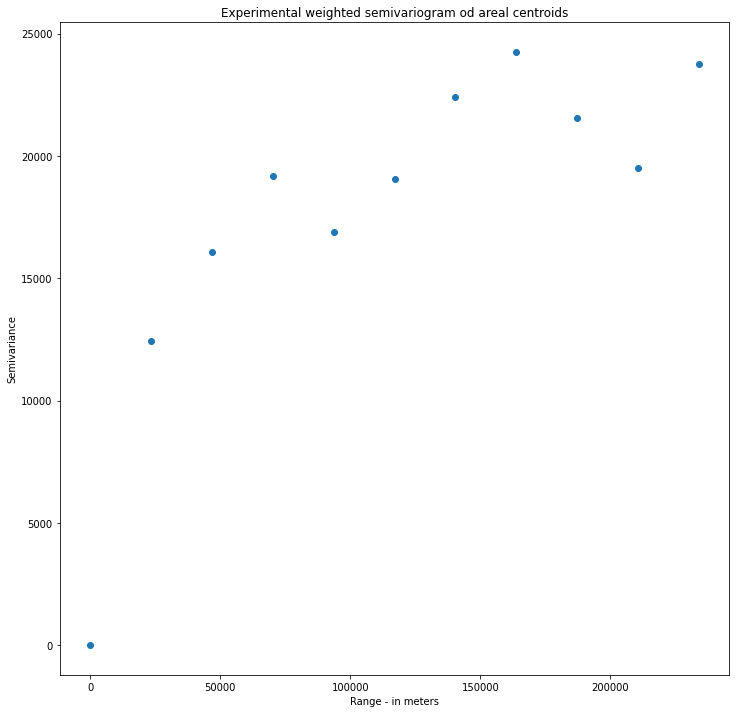

In [12]:
#from pyinterpolate.semivariance import calculate_weighted_semivariance
maximum_range = 236000
step_size = 23400
exp_semivar = calculate_weighted_semivariance(data=areal_weights, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1],'o')
plt.title('Experimental weighted semivariogram od areal centroids')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

In [43]:
Theo_semi = TheoreticalSemivariogramss(areal_data_prepared,empirical_semivariance=exp_semivar,verbose=False)

In [44]:
Theo_semi.find_optimal_models(number_of_ranges = 50)

'exponential'

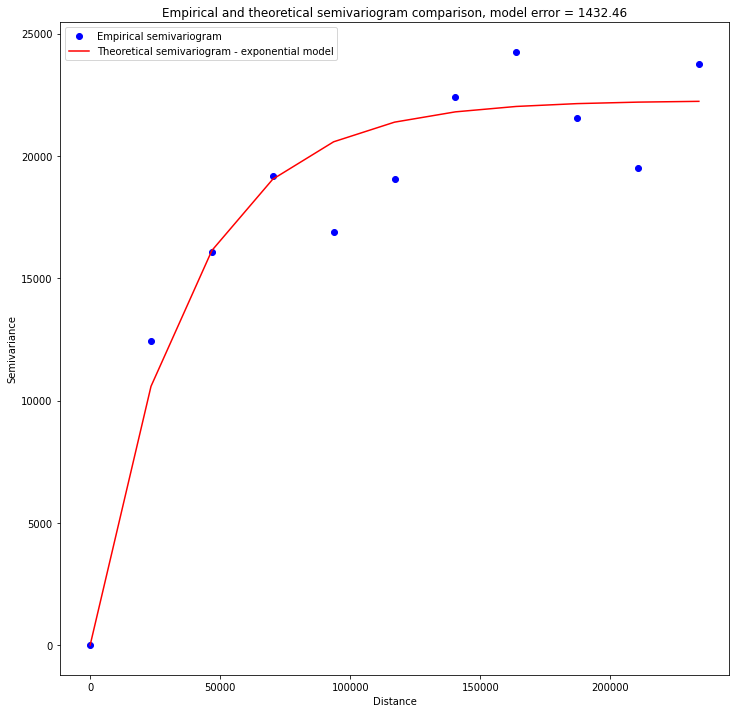

In [45]:
Theo_semi.show_semivariogram()

In [50]:
maximum_range = 236000
step_size = 23400
reg_mod = RegularizedSemivariogram()

In [61]:
maximum_range = 236000
step_size = 23400
reg_mod2 = RegularizedSemivariogram()

In [62]:
reg_mod2.fit(areal_data=areal_data_prepared,
            areal_step_size=step_size, max_areal_range=maximum_range,
            point_support_data=points_in_area, weighted_lags=True, store_models=True)

/home/muji/anaconda3/envs/py37/lib/python3.7/site-packages/pyinterpolate/semivariance/semivariogram_fit/fit_semivariance.py:301: UserWarning: WARNING: linear model fitted to the experimental variogram is better than the core models!
  warnings.warn(warning_msg)
/home/muji/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:250: UserWarning: WARNING: linear model fitted to the experimental variogram is better than the core models!


In [63]:
reg_mod2.transform(max_iters=10)

100%|██████████| 10/10 [15:09<00:00, 90.97s/it]


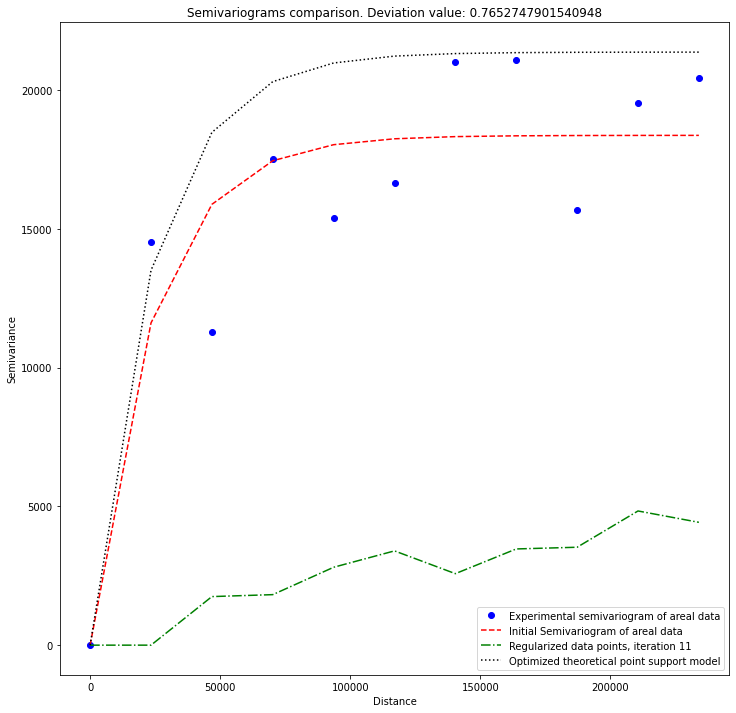

In [64]:
reg_mod2.show_semivariograms()

In [51]:
reg_mod.fit(areal_data=areal_data_prepared,
            areal_step_size=step_size, max_areal_range=maximum_range,
            point_support_data=points_in_area, weighted_lags=True, store_models=True)

/home/muji/anaconda3/envs/py37/lib/python3.7/site-packages/pyinterpolate/semivariance/semivariogram_fit/fit_semivariance.py:301: UserWarning: WARNING: linear model fitted to the experimental variogram is better than the core models!
  warnings.warn(warning_msg)
/home/muji/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:250: UserWarning: WARNING: linear model fitted to the experimental variogram is better than the core models!


In [52]:
reg_mod.transform(max_iters=15)

100%|██████████| 15/15 [24:52<00:00, 99.53s/it] 


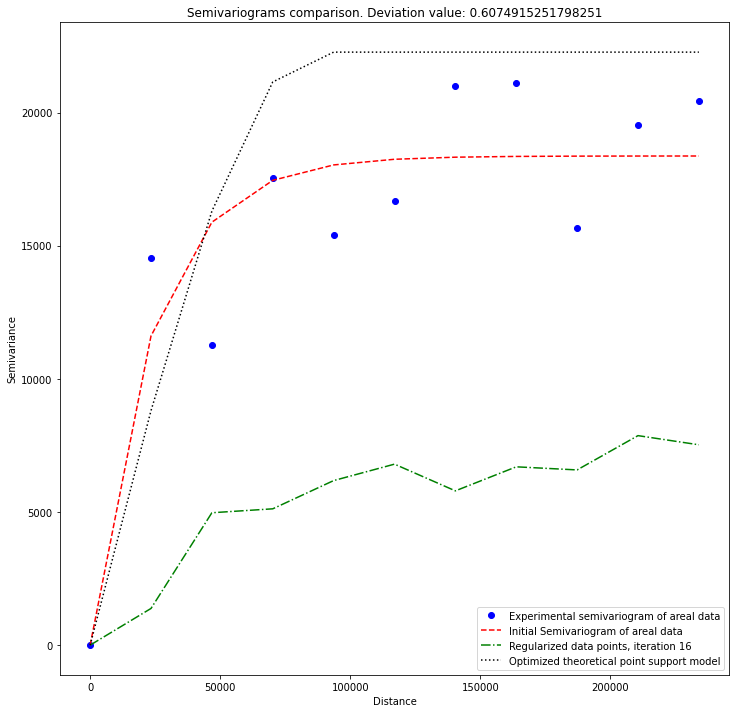

In [53]:
reg_mod.show_semivariograms()

In [68]:
maximum_range = 236000
step_size = 23400
reg_mod3 = RegularizedSemivariogram()
reg_mod3.fit(areal_data=areal_data_prepared,
            areal_step_size=step_size, max_areal_range=maximum_range,
            point_support_data=points_in_area, weighted_lags=True, store_models=True)

/home/muji/anaconda3/envs/py37/lib/python3.7/site-packages/pyinterpolate/semivariance/semivariogram_fit/fit_semivariance.py:301: UserWarning: WARNING: linear model fitted to the experimental variogram is better than the core models!
  warnings.warn(warning_msg)
/home/muji/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:250: UserWarning: WARNING: linear model fitted to the experimental variogram is better than the core models!


In [69]:
reg_mod3.transform(max_iters=10)

100%|██████████| 10/10 [06:46<00:00, 40.65s/it]


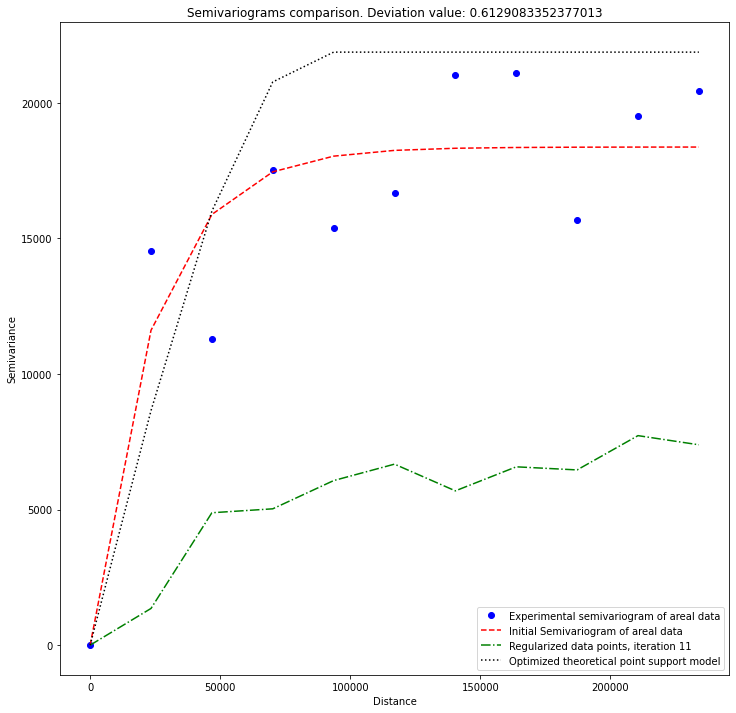

In [70]:
reg_mod3.show_semivariograms()

In [71]:
reg_mod3.export_regularized_model('ATP/regularized_modelJuly203.csv')

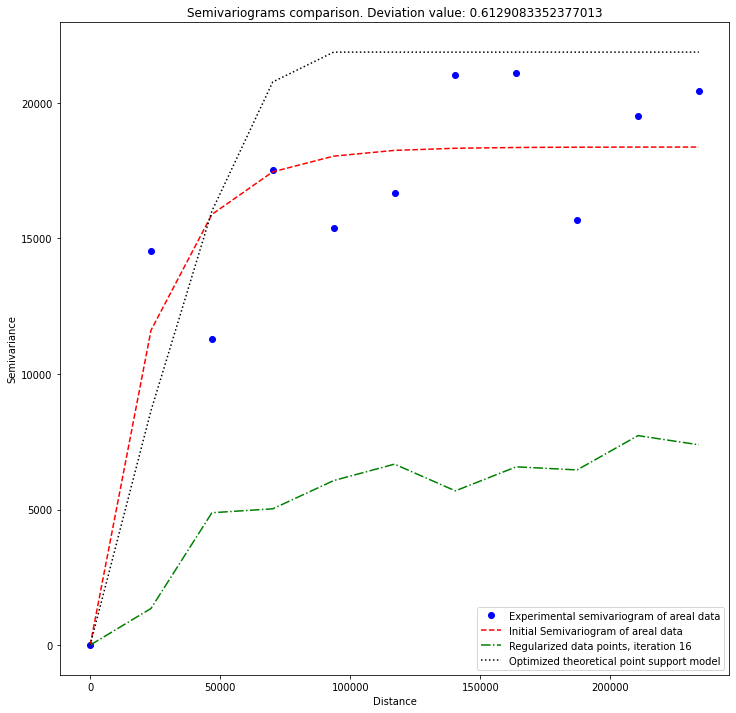

In [73]:
#from scipy import misc
#import imageio
#imageio.imwrite('ATP/semivariograms/semivariograms_april20.png',reg_mod.show_semivariograms())
lags = reg_mod3.experimental_semivariogram_of_areal_data[:, 0]
plt.figure(figsize = (12, 12))
#lags = reg_mod.experimental_semivariogram_of_areal_data[:, 0]
        #plt.figure(figsize=(12, 12))
plt.plot(lags,reg_mod3.experimental_semivariogram_of_areal_data[:, 1], 'bo')
plt.plot(lags,reg_mod3.initial_theoretical_model_of_areal_data.predict(lags), color='r',linestyle='--')
plt.plot(lags, reg_mod3.optimal_regularized_model, color='g',linestyle='-.')
plt.plot(lags,reg_mod3.optimal_theoretical_model.predict(lags), color='black', linestyle='dotted')
plt.legend(['Experimental semivariogram of areal data', 'Initial Semivariogram of areal data',
            'Regularized data points, iteration {}'.format(reg_mod.iter),
            'Optimized theoretical point support model'])
plt.title('Semivariograms comparison. Deviation value: {}'.format(reg_mod3.optimal_deviation))
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.savefig('ATP/semivariograms/semivariograms_July203.png')
plt.show()
#plt.savefig('ATP/semivariograms/semivariograms_april20.png')

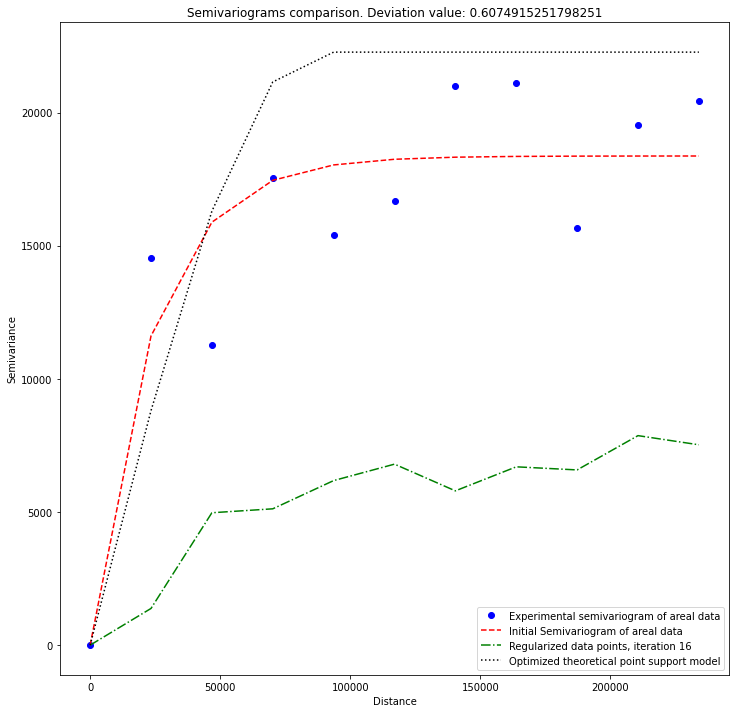

In [55]:
#from scipy import misc
#import imageio
#imageio.imwrite('ATP/semivariograms/semivariograms_april20.png',reg_mod.show_semivariograms())
lags = reg_mod.experimental_semivariogram_of_areal_data[:, 0]
plt.figure(figsize = (12, 12))
#lags = reg_mod.experimental_semivariogram_of_areal_data[:, 0]
        #plt.figure(figsize=(12, 12))
plt.plot(lags,reg_mod.experimental_semivariogram_of_areal_data[:, 1], 'bo')
plt.plot(lags,reg_mod.initial_theoretical_model_of_areal_data.predict(lags), color='r',linestyle='--')
plt.plot(lags, reg_mod.optimal_regularized_model, color='g',linestyle='-.')
plt.plot(lags,reg_mod.optimal_theoretical_model.predict(lags), color='black', linestyle='dotted')
plt.legend(['Experimental semivariogram of areal data', 'Initial Semivariogram of areal data',
            'Regularized data points, iteration {}'.format(reg_mod.iter),
            'Optimized theoretical point support model'])
plt.title('Semivariograms comparison. Deviation value: {}'.format(reg_mod.optimal_deviation))
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.savefig('ATP/semivariograms/semivariograms_July202.png')
plt.show()
#plt.savefig('ATP/semivariograms/semivariograms_april20.png')

In [54]:
reg_mod.export_regularized_model('ATP/regularized_modelJuly202.csv')

In [74]:
from pyinterpolate.semivariance import TheoreticalSemivariogram
semivariogram = TheoreticalSemivariogram()  # Create TheoreticalSemivariogram object
semivariogram.import_model('ATP/regularized_modelJuly202.csv')  # Load regularized semivariogram

In [75]:
number_of_obs = 8
radius = 23400

# Get crs

gdf_crs = gpd.read_file(areal_data).crs
from pyinterpolate.kriging import ArealKriging
kriging_model = ArealKriging(semivariogram_model=semivariogram,
    known_areas=areal_data_prepared,
    known_areas_points=points_in_area,
    kriging_type='atp')

smoothed_area = kriging_model.regularize_data(number_of_neighbours=number_of_obs,
                                              max_search_radius=radius,
                                              data_crs=gdf_crs)

In [76]:
smoothed_area

,id,geometry,reg.est,reg.err,rmse
0,2270,POINT (1297500.000 667500.000),5.654174,46.605159,104.441686
1,2270,POINT (1312500.000 652500.000),173.171742,67.162322,104.441686
2,2270,POINT (1312500.000 667500.000),54.290045,67.414618,104.441686
3,2270,POINT (1312500.000 682500.000),44.058391,55.322408,104.441686
4,2270,POINT (1312500.000 697500.000),6.591350,29.669462,104.441686
...,...,...,...,...,...
4548,2226,POINT (1057500.000 937500.000),0.000000,0.000000,50.701064
4549,2226,POINT (1057500.000 952500.000),0.000000,0.000000,50.701064
4550,2226,POINT (1072500.000 862500.000),0.000000,0.000000,50.701064
4551,2226,POINT (1072500.000 877500.000),1.522900,58.112515,50.701064


In [77]:
smoothed_area['reg.est'].max()

173.1717424198557

In [90]:
smoothed_area.to_file('ATP/smoothed_atp_July/July_236_weighted/smoothed.shp')

CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


In [78]:
from pyinterpolate.semivariance import TheoreticalSemivariogram
semivariogram2 = TheoreticalSemivariogram()  # Create TheoreticalSemivariogram object
semivariogram2.import_model('ATP/regularized_modelJuly20.csv')  # Load regularized semivariogram

In [79]:
number_of_obs = 8
radius = 23400

# Get crs

gdf_crs = gpd.read_file(areal_data).crs
from pyinterpolate.kriging import ArealKriging
kriging_model2 = ArealKriging(semivariogram_model=semivariogram2,
    known_areas=areal_data_prepared,
    known_areas_points=points_in_area,
    kriging_type='atp')

smoothed_area2 = kriging_model2.regularize_data(number_of_neighbours=number_of_obs,
                                              max_search_radius=radius,
                                              data_crs=gdf_crs)

In [80]:
smoothed_area2

,id,geometry,reg.est,reg.err,rmse
0,2270,POINT (1297500.000 667500.000),4.312620,46.467767,50.690608
1,2270,POINT (1312500.000 652500.000),153.024909,75.805397,50.690608
2,2270,POINT (1312500.000 667500.000),43.619972,67.457751,50.690608
3,2270,POINT (1312500.000 682500.000),35.882353,49.809624,50.690608
4,2270,POINT (1312500.000 697500.000),6.400173,30.009523,50.690608
...,...,...,...,...,...
4548,2226,POINT (1057500.000 937500.000),0.000000,0.000000,50.583113
4549,2226,POINT (1057500.000 952500.000),0.000000,0.000000,50.583113
4550,2226,POINT (1072500.000 862500.000),0.000000,0.000000,50.583113
4551,2226,POINT (1072500.000 877500.000),1.506034,56.300302,50.583113


In [81]:
smoothed_area2['reg.est'].max()

153.39445087910633

In [82]:
number_of_obs = 8
radius = 23400

# Get crs

gdf_crs = gpd.read_file(areal_data).crs
from pyinterpolate.kriging import ArealKriging
kriging_model2_ata = ArealKriging(semivariogram_model=semivariogram2,
    known_areas=areal_data_prepared,
    known_areas_points=points_in_area,
    kriging_type='ata')

smoothed_area2_ata = kriging_model2_ata.regularize_data(number_of_neighbours=number_of_obs,
                                              max_search_radius=radius,
                                              data_crs=gdf_crs)

In [83]:
smoothed_area2_ata

,id,geometry,reg.est,reg.err,rmse
0,2270,"POLYGON ((1324305.343725542 725659.2941726296,...",332.461708,57.850081,50.690608
1,5183,"POLYGON ((1135752.778674917 648210.0679091114,...",144.285011,99.635681,95.816311
2,2265,"POLYGON ((1249131.681264679 614870.3974717301,...",81.727099,60.209461,158.663201
3,4913,"POLYGON ((1228880.019879213 582279.0008932372,...",198.826412,84.960719,125.723512
4,2237,"POLYGON ((1298169.989699582 595378.4957735761,...",192.109793,0.000000,42.563393
5,2262,"(POLYGON ((456481.7415631314 2026226.19066819,...",63.216015,54.776830,0.012015
6,2253,"POLYGON ((1297167.296807085 659975.7731191884,...",263.236203,16.986283,175.604897
7,2242,(POLYGON ((1147832.449516126 567241.9986961872...,251.283483,72.736581,23.190483
8,2266,"POLYGON ((1267837.848945254 692444.5025084217,...",207.923861,69.404570,35.536161
9,2227,"POLYGON ((1271083.3472428 582033.6238527499, 1...",265.066137,28.191170,160.288237


In [84]:
number_of_obs = 8
radius = 23400

# Get crs

gdf_crs = gpd.read_file(areal_data).crs
from pyinterpolate.kriging import ArealKriging
kriging_model_ata = ArealKriging(semivariogram_model=semivariogram,
    known_areas=areal_data_prepared,
    known_areas_points=points_in_area,
    kriging_type='ata')

smoothed_area_ata = kriging_model_ata.regularize_data(number_of_neighbours=number_of_obs,
                                              max_search_radius=radius,
                                              data_crs=gdf_crs)

In [85]:
smoothed_area_ata

,id,geometry,reg.est,reg.err,rmse
0,2270,"POLYGON ((1324305.343725542 725659.2941726296,...",386.212786,42.452093,104.441686
1,5183,"POLYGON ((1135752.778674917 648210.0679091114,...",186.419389,76.860995,137.950689
2,2265,"POLYGON ((1249131.681264679 614870.3974717301,...",13.737536,0.000000,226.652764
3,4913,"POLYGON ((1228880.019879213 582279.0008932372,...",220.578658,70.086913,147.475758
4,2237,"POLYGON ((1298169.989699582 595378.4957735761,...",113.658585,0.000000,35.887815
5,2262,"(POLYGON ((456481.7415631314 2026226.19066819,...",62.539296,33.872868,0.664704
6,2253,"POLYGON ((1297167.296807085 659975.7731191884,...",268.018673,0.000000,170.822427
7,2242,(POLYGON ((1147832.449516126 567241.9986961872...,275.037842,53.529477,46.944842
8,2266,"POLYGON ((1267837.848945254 692444.5025084217,...",227.073553,52.581351,54.685853
9,2227,"POLYGON ((1271083.3472428 582033.6238527499, 1...",260.331290,0.000000,155.553390


In [91]:
smoothed_area_ata.to_file('ATA/smoothed_ata_July/July_236_weighted/smoothed.shp')

CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


In [86]:
print(smoothed_area2_ata['rmse'].max())

328.95788663260805


In [87]:
print(smoothed_area_ata['rmse'].max())

311.47301621011366


In [88]:
print(smoothed_area2_ata['reg.err'].max())
print(smoothed_area_ata['reg.err'].max())

123.05019208806526
134.14884653160837


In [89]:
print(smoothed_area2_ata['reg.est'].max())
print(smoothed_area_ata['reg.est'].max())

332.4617079534709
386.2127855641776


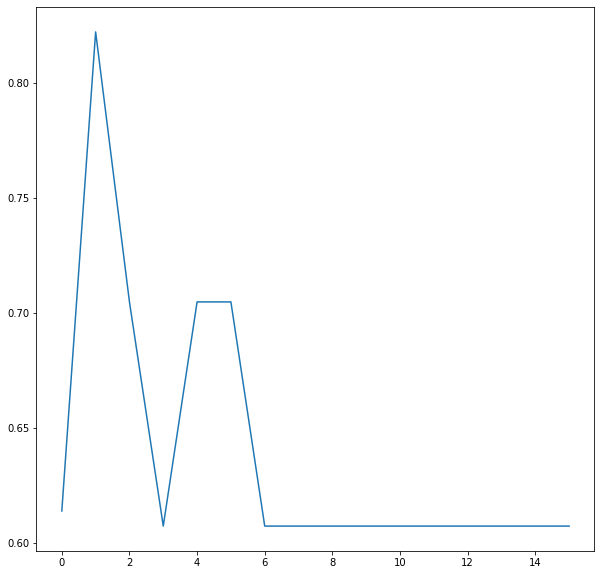

In [92]:
# First analyze deviation

plt.figure(figsize=(10, 10))
plt.plot(reg_mod.deviations)
plt.show()

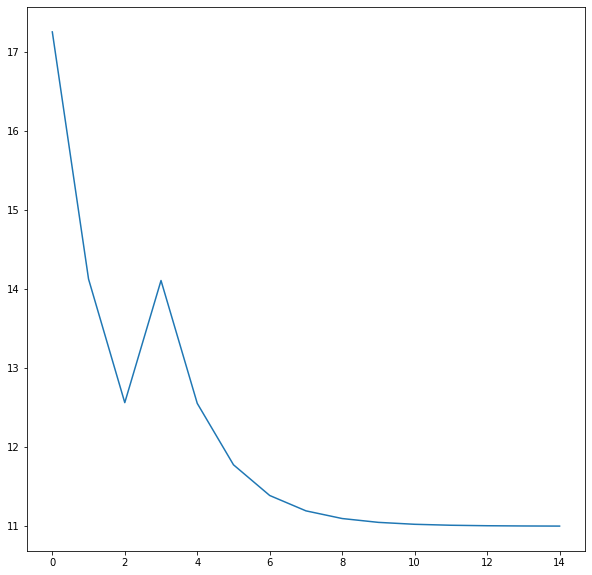

In [93]:
weights = reg_mod.weights
weights = [sum(w) for w in weights]

plt.figure(figsize=(10,10))
plt.plot(weights)
plt.show()

In [94]:
rectangles = gpd.read_file('census_data_use/python_rectangles/rectangles_15kJuly20/rectangles_POPrs.shp')

In [95]:
#rectangles
smoothed_area = gpd.read_file('ATP/smoothed_atp_June/June_236_2/smoothed.shp')
ndf = gpd.sjoin(smoothed_area, rectangles, how='left', op='intersects')
ndf['index_right'] = ndf.index_right.astype(int)+1
ndf
#smoothed_area

,id,reg.est,reg.err,rmse,geometry,index_right,left,bottom,right,top,NUMPOINTS,ID,POP_Rs1
0,2270,3.903862,45.052913,47.779179,POINT (1297500.000 667500.000),4482,1290000.0,660000.0,1305000.0,675000.0,134.0,4482,13795.6460
1,2270,140.289041,73.806531,47.779179,POINT (1312500.000 652500.000),4511,1305000.0,645000.0,1320000.0,660000.0,1835.0,4511,323248.5472
2,2270,40.033237,65.501482,47.779179,POINT (1312500.000 667500.000),4512,1305000.0,660000.0,1320000.0,675000.0,761.0,4512,121599.9724
3,2270,32.952211,48.250138,47.779179,POINT (1312500.000 682500.000),4513,1305000.0,675000.0,1320000.0,690000.0,865.0,4513,138378.9101
4,2270,5.870689,29.056952,47.779179,POINT (1312500.000 697500.000),4514,1305000.0,690000.0,1320000.0,705000.0,300.0,4514,34106.4128
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4548,2226,0.000000,0.000000,46.521963,POINT (1057500.000 937500.000),3668,1050000.0,930000.0,1065000.0,945000.0,0.0,3668,0.0000
4549,2226,0.000000,0.000000,46.521963,POINT (1057500.000 952500.000),3669,1050000.0,945000.0,1065000.0,960000.0,0.0,3669,0.0000
4550,2226,0.000000,0.000000,46.521963,POINT (1072500.000 862500.000),3715,1065000.0,855000.0,1080000.0,870000.0,0.0,3715,0.0000
4551,2226,1.346605,54.197733,46.521963,POINT (1072500.000 877500.000),3716,1065000.0,870000.0,1080000.0,885000.0,62.0,3716,2093.1781


In [96]:
ndf.to_file('ATP/smoothed_atp_July/july_236_combine/smoothed_combine.shp')

CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING
CPLE_NotSupported in Normalized/laundered field name: 'index_right' to 'index_righ'
CPLE_NotSupported in Normalized/laundered field name: 'ID' to 'ID_1'


No handles with labels found to put in legend.


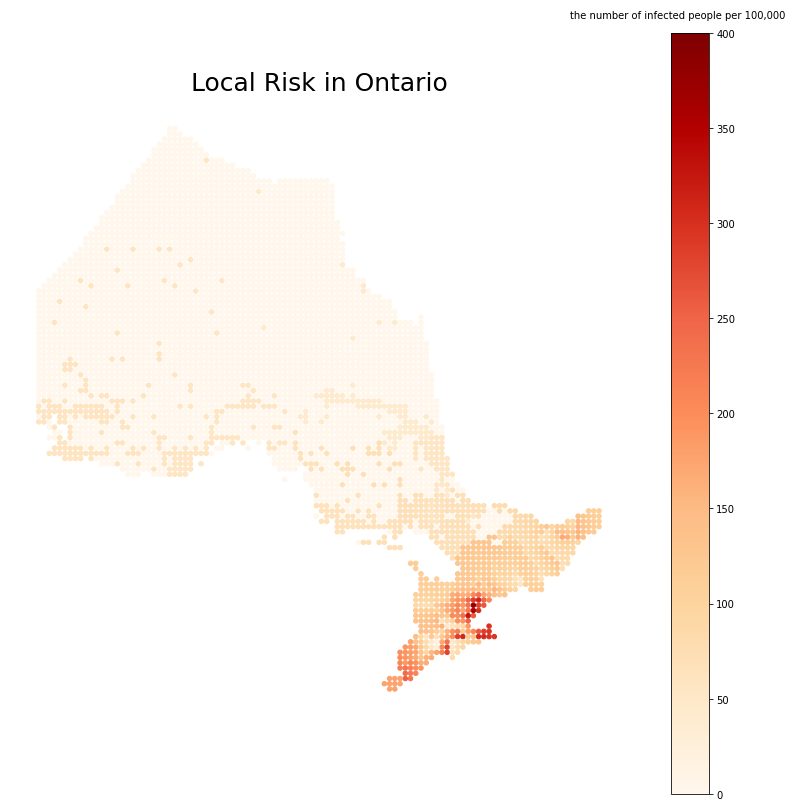

In [97]:
#fig, ax = plt.subplots(1, figsize=(14, 14), dpi=200)
fs = (14, 14)
areal_data = 'age_adjusted/areal_dataJuly20/areal_July20.shp'
smoothed_df_combine = gpd.read_file('ATP/smoothed_atp_July/July_df_combine/smoothed_df_combine.shp')
gdf = gpd.read_file(areal_data)
base = gdf.plot(figsize=(14, 14), color='white')
output_map = smoothed_df_combine.copy()
fig = output_map.plot(ax=base,column='local_risk', cmap='OrRd',legend=True, figsize=fs,markersize=20,vmax=400)
fig.set_title('Local Risk in Ontario', fontdict={
             'fontsize': '25', 'fontweight': '1'})
fig.legend(bbox_to_anchor=(1.26, 1.15), prop={'size': 10},title=('the number of infected people per 100,000'),frameon=False)
fig.set_axis_off()
plt.savefig('ATP/smoothed_atp_July/local_risk_July20.png')
#print(type(fig))

No handles with labels found to put in legend.


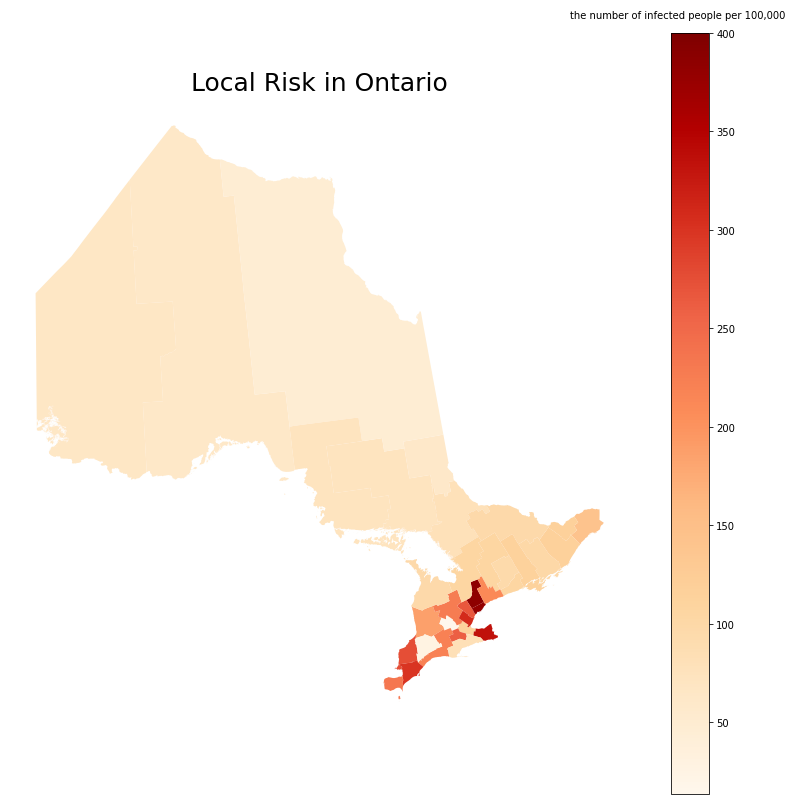

In [99]:
import matplotlib.pyplot as plt
fs = (14, 14)
areal_data = 'age_adjusted/areal_dataJuly20/areal_July20.shp'
output_map1 = smoothed_area_ata.copy()
#areal_data = 'areal_data/areal_data.shp'
gdf = gpd.read_file(areal_data)
#base = gdf.plot(figsize=(14, 14), color='white')
#smoothed_area.plot(ax=base, column='reg.est', cmap='Spectral_r', legend=True, markersize=20, vmax=500)
base = gdf.plot(figsize=(14, 14), color='white')
fig = output_map1.plot(ax=base,column='reg.est', cmap='OrRd',legend=True, figsize=fs,markersize=20,vmax=400)
fig.set_title('Local Risk in Ontario', fontdict={
             'fontsize': '25', 'fontweight': '1'})
fig.legend(bbox_to_anchor=(1.26, 1.15), prop={'size': 10},title=('the number of infected people per 100,000'),frameon=False)
fig.set_axis_off()
plt.savefig('ATA/smoothed_ata_July/local_risk_July.png')